# Sentinel-2 test

In [1]:
# Load packages (need to be installed in the environment)
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with rasterio.open('Data/S2B_20240823T101559_davos.tif') as src:
    dav_s2 = src.read()

In [ ]:
print(dav_s2[7])

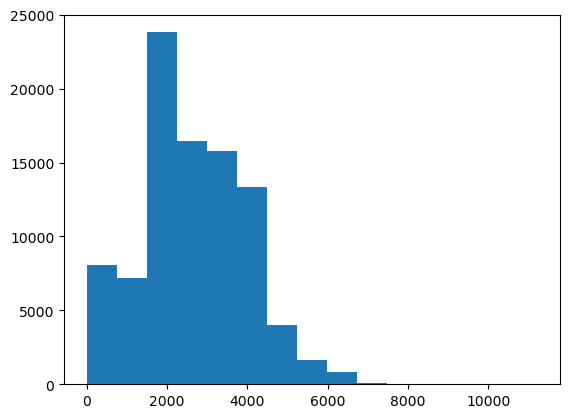

In [3]:
plt.hist(dav_s2[7].flatten(), bins=15)
plt.show()

In [4]:
# Divide by 10'000 to get reflectance in %
dav_s2 = dav_s2/10000

# Fill 0 with NaN
dav_s2[dav_s2 == 0] = np.nan

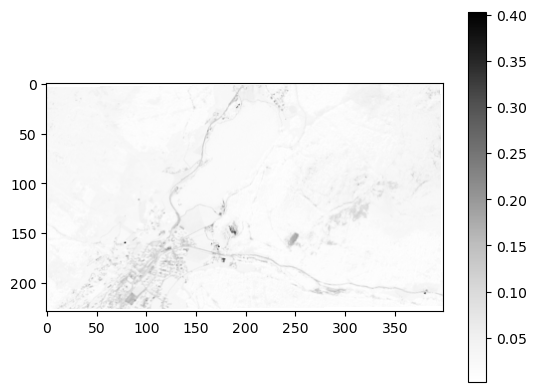

In [9]:
plt.imshow(dav_s2[1], cmap='Greys')
plt.colorbar()
plt.show()

In [6]:
# NDVI
# B4 = 3, B8 = 7 (both 10m resolution)
dav_ndvi = (dav_s2[7]-dav_s2[3])/(dav_s2[7]+dav_s2[3])

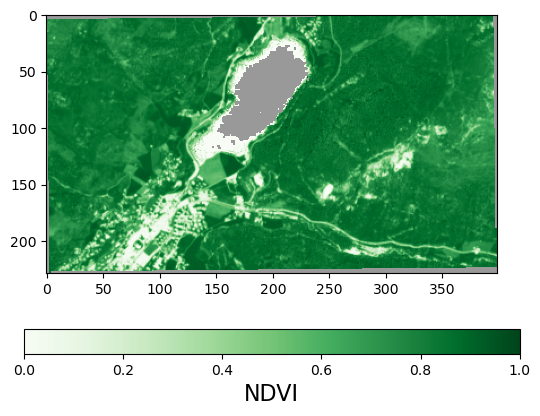

In [8]:
cmap = plt.get_cmap('Greens')
cmap.set_bad(color='black', alpha=0.4)
plt.imshow(dav_ndvi, cmap=cmap, vmin=0, vmax=1)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('NDVI', fontsize=16)
plt.show()

In [ ]:
plt.hist(dav_ndvi.flatten(), bins=20)
plt.show()

In [ ]:
# Normalized difference water index (NDWI) Gao et al. 1996 using bands 8A (NIR) and 11 (SWIR) -> for drought monitoring etc.

# B8A = 8, B11 = 11 (both 20m resolution)
dav_ndwi = (dav_s2[8]-dav_s2[11])/(dav_s2[8]+dav_s2[11])


In [ ]:
cmap = plt.get_cmap('Blues')
cmap.set_bad(color='black', alpha=0.4)
plt.imshow(dav_ndwi, cmap=cmap)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('NDWI', fontsize=16)
plt.show()

In [ ]:
# Waterbody detection by McFeeters using bands 3 (green) and 8A (NIR) -> dification of normalised difference water index (MNDWI)

# B3 = 2 (10m), B8A = 8 (20m)
dav_mndwi = (dav_s2[2]-dav_s2[8])/(dav_s2[2]+dav_s2[8])


In [ ]:
cmap = plt.get_cmap('Blues')
cmap.set_bad(color='black', alpha=0.4)
plt.imshow(dav_mndwi, cmap=cmap)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('MNDWI', fontsize=16)
plt.show()